In [203]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from typing import Any, List, Dict, Tuple
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


df = pd.read_csv('/kaggle/input/passenger-list-for-the-estonia-ferry-disaster/estonia-passenger-list.csv')
df

,PassengerId,Country,Firstname,Lastname,Sex,Age,Category,Survived
0,1,Sweden,ARVID KALLE,AADLI,M,62,P,0
1,2,Estonia,LEA,AALISTE,F,22,C,0
2,3,Estonia,AIRI,AAVASTE,F,21,C,0
3,4,Sweden,JURI,AAVIK,M,53,C,0
4,5,Sweden,BRITTA ELISABET,AHLSTROM,F,55,P,0
...,...,...,...,...,...,...,...,...
984,985,Sweden,ANNA INGRID BIRGITTA,OSTROM,F,60,P,0
985,986,Sweden,ELMAR MIKAEL,OUN,M,34,P,1
986,987,Sweden,ENN,QUNAPUU,M,77,P,0
987,988,Sweden,LY,GUNAPUU,F,87,P,0


In [129]:
X = df.drop('Survived', axis=1)
X

,PassengerId,Country,Firstname,Lastname,Sex,Age,Category
0,1,Sweden,ARVID KALLE,AADLI,M,62,P
1,2,Estonia,LEA,AALISTE,F,22,C
2,3,Estonia,AIRI,AAVASTE,F,21,C
3,4,Sweden,JURI,AAVIK,M,53,C
4,5,Sweden,BRITTA ELISABET,AHLSTROM,F,55,P
...,...,...,...,...,...,...,...
984,985,Sweden,ANNA INGRID BIRGITTA,OSTROM,F,60,P
985,986,Sweden,ELMAR MIKAEL,OUN,M,34,P
986,987,Sweden,ENN,QUNAPUU,M,77,P
987,988,Sweden,LY,GUNAPUU,F,87,P


In [130]:
y = df['Survived']
y

0      0
1      0
2      0
3      0
4      0
      ..
984    0
985    1
986    0
987    0
988    1
Name: Survived, Length: 989, dtype: int64

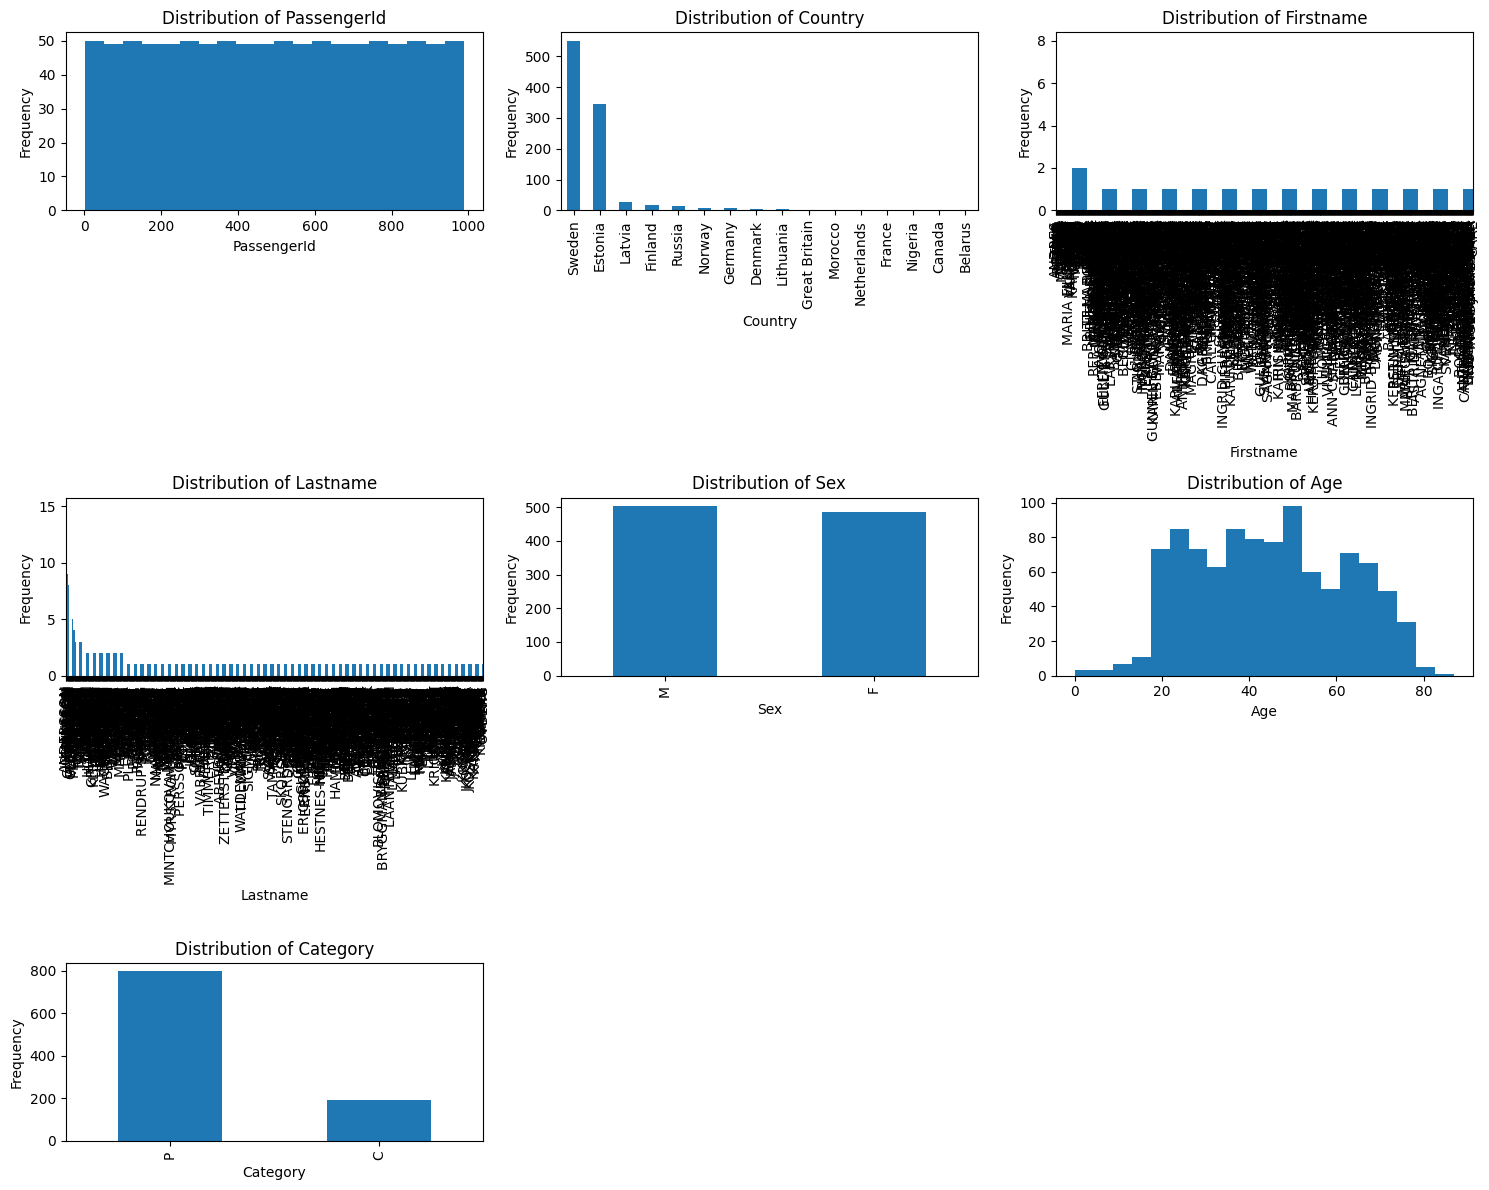

In [131]:
num_columns = len(X.columns)
cols = 3  # Number of columns in the grid (adjust as needed)
rows = math.ceil(num_columns / cols)

# Create a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))  # Adjust figure size as needed
axes = axes.flatten()  # Flatten to easily iterate over axes

for i, column in enumerate(X.columns):
    ax = axes[i]
    if X[column].dtype == 'object' or len(X[column].unique()) < 20:
        # For categorical or discrete features, use a bar plot
        X[column].value_counts().plot(kind='bar', ax=ax)
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')
    else:
        # For continuous features, use a histogram
        X[column].plot(kind='hist', bins=20, ax=ax)
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout for readability
plt.show()

As we can see, almost every object has unique Firstname and Lastname, and PassengerId is just an identificational number, so, we can drop these features because they won't benefit our model.

In [132]:
X.drop(['PassengerId', 'Firstname', 'Lastname'], axis=1, inplace=True)
X

,Country,Sex,Age,Category
0,Sweden,M,62,P
1,Estonia,F,22,C
2,Estonia,F,21,C
3,Sweden,M,53,C
4,Sweden,F,55,P
...,...,...,...,...
984,Sweden,F,60,P
985,Sweden,M,34,P
986,Sweden,M,77,P
987,Sweden,F,87,P


In [133]:
y.value_counts()

Survived
0    852
1    137
Name: count, dtype: int64

In [134]:
y.value_counts() / len(y)

Survived
0    0.861476
1    0.138524
Name: count, dtype: float64

In [135]:
X.isna().any()

Country     False
Sex         False
Age         False
Category    False
dtype: bool

In [136]:
df['Country'].nunique()

16

**Binarization of Country, Sex and Category:**

In [137]:
X = pd.get_dummies(X, columns=['Country', 'Sex', 'Category'], drop_first=False)
X

,Age,Country_Belarus,Country_Canada,Country_Denmark,Country_Estonia,Country_Finland,Country_France,Country_Germany,Country_Great Britain,Country_Latvia,...,Country_Morocco,Country_Netherlands,Country_Nigeria,Country_Norway,Country_Russia,Country_Sweden,Sex_F,Sex_M,Category_C,Category_P
0,62,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,True
1,22,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
2,21,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
3,53,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,True,False
4,55,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,60,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,True
985,34,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,True
986,77,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,True
987,87,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,True


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

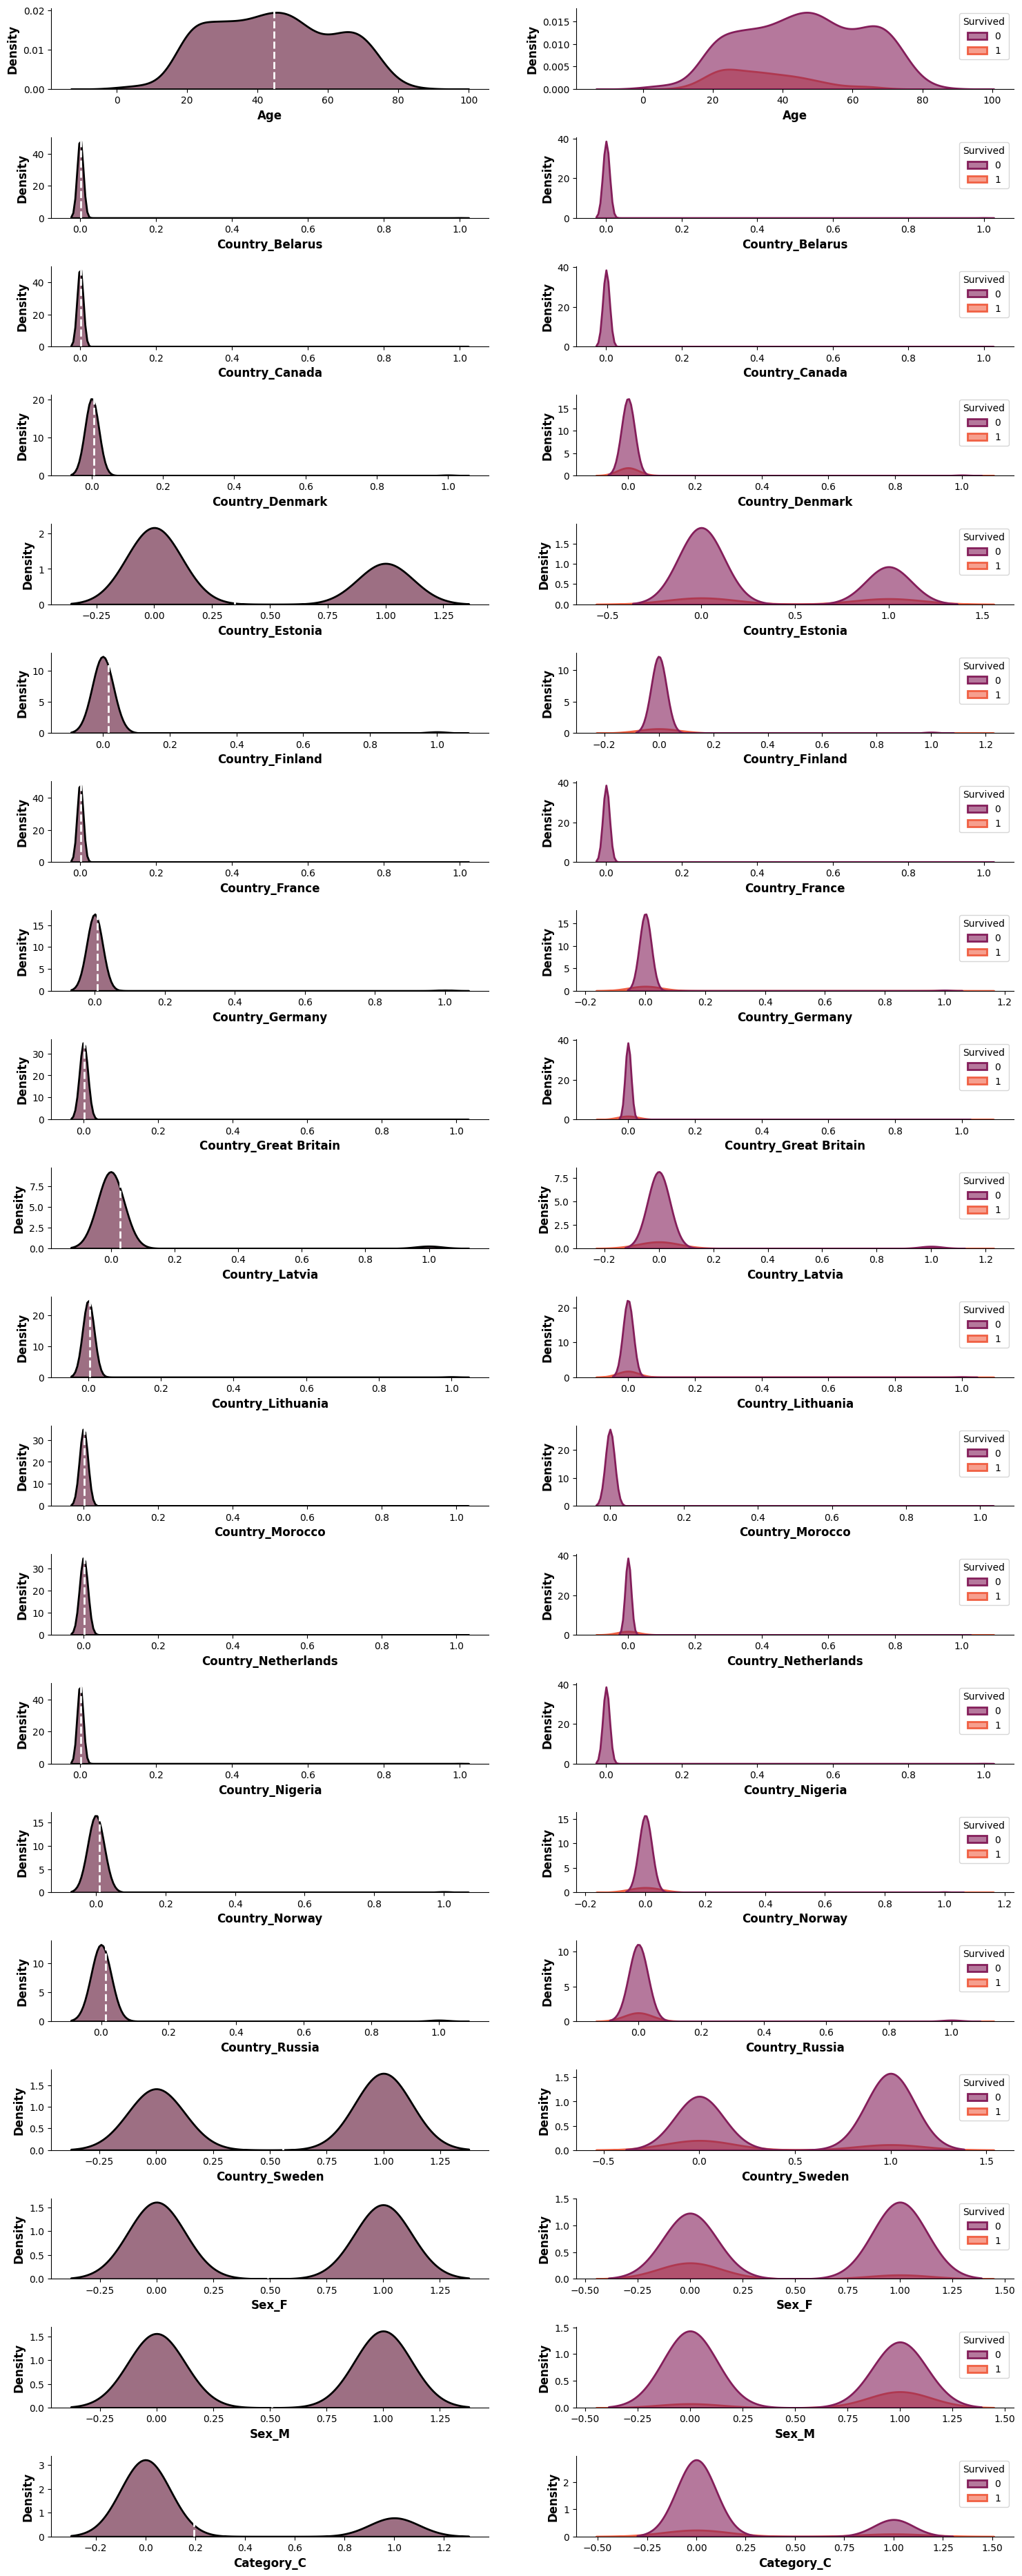

In [138]:
plotIndex = 1
plt.figure(figsize=(18,50))
for i in range(1, len(X.columns)):
    plt.subplot(len(X.columns), 2, plotIndex)
    sns.kdeplot(data=X, x=X.columns[i-1], 
                fill=True, linewidth=2, color='#5c1031', alpha=0.6, edgecolor='k')
    plt.axvline(X[X.columns[i-1]].mean(), color='white', linestyle='--', linewidth=2)
    plt.xlabel(xlabel=X.columns[i-1].title(), fontsize=12, weight='bold')
    plt.ylabel(ylabel='Density', fontsize=12, weight='bold')
    sns.despine()

    plt.subplot(len(X.columns), 2, plotIndex+1)
    sns.kdeplot(data=X, x=X.columns[i-1], 
                fill=True, hue=y, linewidth=2, palette='rocket', alpha=0.6)
    plt.xlabel(xlabel=X.columns[i-1].title(), fontsize=12, weight='bold')
    plt.ylabel(ylabel='Density', fontsize=12, weight='bold')
    sns.despine()

    
    plotIndex += 2
plt.subplots_adjust(hspace=0.6)    
plt.show()

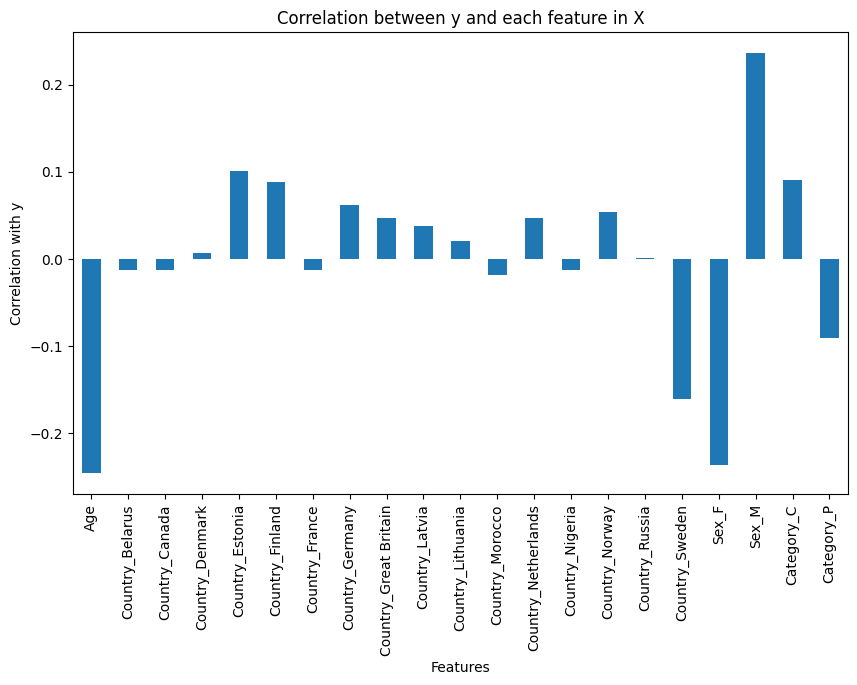

In [139]:
correlations = X.corrwith(y)
correlations.plot(kind='bar', figsize=(10, 6))
plt.title('Correlation between y and each feature in X')
plt.xlabel('Features')
plt.ylabel('Correlation with y')
plt.show()

In [140]:
max(df['Age'])

87

**Binarization of Age:**

In [141]:
thresholds = [0, 26, 35, 44, 52, 61, 70]

In [142]:
for threshold in thresholds:
    X[f'Age_le_{threshold}'] = X['Age'] <= threshold
    X[f'Age_ge_{threshold}'] = X['Age'] >= threshold
X_binarized = X.drop('Age', axis= 1)
X_binarized

,Country_Belarus,Country_Canada,Country_Denmark,Country_Estonia,Country_Finland,Country_France,Country_Germany,Country_Great Britain,Country_Latvia,Country_Lithuania,...,Age_le_35,Age_ge_35,Age_le_44,Age_ge_44,Age_le_52,Age_ge_52,Age_le_61,Age_ge_61,Age_le_70,Age_ge_70
0,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,True,False,True,True,False
1,False,False,False,True,False,False,False,False,False,False,...,True,False,True,False,True,False,True,False,True,False
2,False,False,False,True,False,False,False,False,False,False,...,True,False,True,False,True,False,True,False,True,False
3,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,True,True,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,True,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,True,True,False,True,False
985,False,False,False,False,False,False,False,False,False,False,...,True,False,True,False,True,False,True,False,True,False
986,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,True,False,True,False,True
987,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,True,False,True,False,True


In [91]:
# X['Age ≥ 0'] = X['Age'].apply(lambda x: 1 if x >= 0 else 0)
# X['Age ≥ 26'] = X['Age'].apply(lambda x: 1 if x >= 26 else 0)
# X['Age ≥ 35'] = X['Age'].apply(lambda x: 1 if x >= 35 else 0)
# X['Age ≥ 44'] = X['Age'].apply(lambda x: 1 if x >= 44 else 0)
# X['Age ≥ 52'] = X['Age'].apply(lambda x: 1 if x >= 52 else 0)
# X['Age ≥ 61'] = X['Age'].apply(lambda x: 1 if x >= 61 else 0)
# X['Age ≥ 70'] = X['Age'].apply(lambda x: 1 if x >= 70 else 0)

# X_binarized = X.drop('Age', axis= 1)
# X_binarized

,Country_Belarus,Country_Canada,Country_Denmark,Country_Estonia,Country_Finland,Country_France,Country_Germany,Country_Great Britain,Country_Latvia,Country_Lithuania,...,Sex_M,Category_C,Category_P,Age ≥ 0,Age ≥ 26,Age ≥ 35,Age ≥ 44,Age ≥ 52,Age ≥ 61,Age ≥ 70
0,False,False,False,False,False,False,False,False,False,False,...,True,False,True,1,1,1,1,1,1,0
1,False,False,False,True,False,False,False,False,False,False,...,False,True,False,1,0,0,0,0,0,0
2,False,False,False,True,False,False,False,False,False,False,...,False,True,False,1,0,0,0,0,0,0
3,False,False,False,False,False,False,False,False,False,False,...,True,True,False,1,1,1,1,1,0,0
4,False,False,False,False,False,False,False,False,False,False,...,False,False,True,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,False,False,False,False,False,False,False,False,False,False,...,False,False,True,1,1,1,1,1,0,0
985,False,False,False,False,False,False,False,False,False,False,...,True,False,True,1,1,0,0,0,0,0
986,False,False,False,False,False,False,False,False,False,False,...,True,False,True,1,1,1,1,1,1,1
987,False,False,False,False,False,False,False,False,False,False,...,False,False,True,1,1,1,1,1,1,1


In [143]:
X_train, X_test, y_train, y_test = train_test_split(X_binarized, y, test_size=0.2, stratify=y, random_state=43)

# **Lazy FCA baseline:**

In [144]:
class LazyClassifierFCA:
    def __init__(self):
        self.X_train = None
        self.y_train = None

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series) -> None:
        self.X_train = X_train
        self.y_train = y_train
        
    def classify_sample(self, sample: pd.Series) -> Any:
        # Split X_train into positive and negative classes
        X_train_positive = self.X_train[y_train == 1]
        X_train_negative = self.X_train[y_train == 0]
        
        positive_classifiers = 0
        negative_classifiers = 0
        
        # Function to check if intersection with a train sample is a positive classifier
        def is_positive_classifier(intersection):
            # Find samples in X_train_positive that contain the intersection
            num_positive = ((X_train_positive | ~intersection) == True).all(axis=1).sum()
            num_negative = ((X_train_negative | ~intersection) == True).all(axis=1).sum()
            return num_negative == 0 and num_positive > 1
        
        # Function to check if intersection is a negative classifier
        def is_negative_classifier(intersection):
            # Find samples in X_train_negative that contain the intersection
            num_positive = ((X_train_positive | ~intersection) == True).all(axis=1).sum()
            num_negative = ((X_train_negative | ~intersection) == True).all(axis=1).sum()
            return num_positive == 0 and num_negative > 1
        
        # Check for positive classifiers by intersecting sample with each positive object
        for _, pos_sample in X_train_positive.iterrows():
            intersection = sample & pos_sample
            if is_positive_classifier(intersection):
                positive_classifiers += 1

        # Check for negative classifiers by intersecting sample with each negative object
        for _, neg_sample in X_train_negative.iterrows():
            intersection = sample & neg_sample
            if is_negative_classifier(intersection):
                negative_classifiers += 1

        # Determine the class based on the number of classifiers
        if positive_classifiers > negative_classifiers:
            print(f"sample {sample.name} is classified as 1, {positive_classifiers=}, {negative_classifiers=}")
            return 1  # Predict positive
            
        elif negative_classifiers > positive_classifiers:
            print(f"sample {sample.name} is classified as 0, {positive_classifiers=}, {negative_classifiers=}")
            return 0  # Predict negative

        else:
            # If equal, you can decide on a rule, like defaulting to 0 or 1, or returning 'undetermined'
            print(f"sample {sample.name} is classified as 1, default, {positive_classifiers=}, {negative_classifiers=}")
        
            return 1  # or 0, depending on the choice


    def predict(self, X_test: pd.DataFrame) -> List[Any]:
        # List to store predictions for each test sample
        predictions = []
        
        # Iterate through each sample in X_test
        for _, sample in X_test.iterrows():
            # Classify the sample and append the result to predictions
            prediction = self.classify_sample(sample)
            predictions.append(prediction)
        
        return predictions

In [145]:
sample = X_test.iloc[1]
y.iloc[1]

0

In [146]:
len(X_train[y_train == 1]), len(X_train[y_train == 0])

(110, 681)

In [147]:
pos_X_train = X_train[y_train == 1]
neg_X_train = X_train[y_train == 0]
len(pos_X_train), len(neg_X_train)

(110, 681)

In [148]:
classifier = LazyClassifierFCA()
classifier.fit(X_train, y_train)

In [149]:
classifier.classify_sample(sample)

sample 896 is classified as 1, default, positive_classifiers=0, negative_classifiers=0


1

In [150]:
y_pred = classifier.predict(X_test)

sample 118 is classified as 0, positive_classifiers=2, negative_classifiers=3
sample 896 is classified as 1, default, positive_classifiers=0, negative_classifiers=0
sample 960 is classified as 1, default, positive_classifiers=0, negative_classifiers=0
sample 761 is classified as 1, default, positive_classifiers=0, negative_classifiers=0
sample 714 is classified as 1, default, positive_classifiers=0, negative_classifiers=0
sample 43 is classified as 0, positive_classifiers=0, negative_classifiers=83
sample 946 is classified as 1, default, positive_classifiers=0, negative_classifiers=0
sample 973 is classified as 1, default, positive_classifiers=0, negative_classifiers=0
sample 627 is classified as 0, positive_classifiers=0, negative_classifiers=33
sample 480 is classified as 1, default, positive_classifiers=0, negative_classifiers=0
sample 294 is classified as 1, default, positive_classifiers=0, negative_classifiers=0
sample 297 is classified as 0, positive_classifiers=0, negative_class

In [151]:
f1_score(y_test, y_pred), accuracy_score(y_test, y_pred)

(0.2692307692307693, 0.42424242424242425)

In [154]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(63, 108, 6, 21)

In [157]:
precision_score(y_test, y_pred)

0.16279069767441862

In [158]:
recall_score(y_test, y_pred)

0.7777777777777778

In [161]:
print('True Negative Rate:', tn/(tn+fp))
print('Negative Predictive Value:', tn/(tn+fn))
print('False Positive Rate:', fp/(tn+fp))
print('False Discovery Rate:', tp/(tp+fp))

True Negative Rate: 0.3684210526315789
Negative Predictive Value: 0.9130434782608695
False Positive Rate: 0.631578947368421
False Discovery Rate: 0.16279069767441862


As we can see, on such a complex data when classes are hard to distinguish, this model gives scores that are less than constant model can give (the situation is exacerbated by the imbalance of classes). So let's compare it to other models. 

In [166]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [167]:
f1_score(y_test, y_pred), accuracy_score(y_test, y_pred)

(0.05405405405405406, 0.8232323232323232)

In [168]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(162, 9, 26, 1)

In [169]:
precision_score(y_test, y_pred)

0.1

In [170]:
recall_score(y_test, y_pred)

0.037037037037037035

In [171]:
print('True Negative Rate:', tn/(tn+fp))
print('Negative Predictive Value:', tn/(tn+fn))
print('False Positive Rate:', fp/(tn+fp))
print('False Discovery Rate:', tp/(tp+fp))

True Negative Rate: 0.9473684210526315
Negative Predictive Value: 0.8617021276595744
False Positive Rate: 0.05263157894736842
False Discovery Rate: 0.1


In [172]:
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [173]:
f1_score(y_test, y_pred), accuracy_score(y_test, y_pred)

(0.2587064676616916, 0.2474747474747475)

In [174]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(23, 148, 1, 26)

In [175]:
precision_score(y_test, y_pred)

0.14942528735632185

In [176]:
recall_score(y_test, y_pred)

0.9629629629629629

In [177]:
print('True Negative Rate:', tn/(tn+fp))
print('Negative Predictive Value:', tn/(tn+fn))
print('False Positive Rate:', fp/(tn+fp))
print('False Discovery Rate:', tp/(tp+fp))

True Negative Rate: 0.13450292397660818
Negative Predictive Value: 0.9583333333333334
False Positive Rate: 0.8654970760233918
False Discovery Rate: 0.14942528735632185


In [178]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [179]:
f1_score(y_test, y_pred), accuracy_score(y_test, y_pred)

(0.11428571428571428, 0.8434343434343434)

In [180]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(165, 6, 25, 2)

In [181]:
precision_score(y_test, y_pred)

0.25

In [182]:
recall_score(y_test, y_pred)

0.07407407407407407

In [183]:
print('True Negative Rate:', tn/(tn+fp))
print('Negative Predictive Value:', tn/(tn+fn))
print('False Positive Rate:', fp/(tn+fp))
print('False Discovery Rate:', tp/(tp+fp))

True Negative Rate: 0.9649122807017544
Negative Predictive Value: 0.868421052631579
False Positive Rate: 0.03508771929824561
False Discovery Rate: 0.25


In [184]:
model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [185]:
f1_score(y_test, y_pred), accuracy_score(y_test, y_pred)

(0.0, 0.8636363636363636)

In [186]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(171, 0, 27, 0)

In [187]:
precision_score(y_test, y_pred)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [188]:
recall_score(y_test, y_pred)

0.0

In [189]:
print('True Negative Rate:', tn/(tn+fp))
print('Negative Predictive Value:', tn/(tn+fn))
print('False Positive Rate:', fp/(tn+fp))
print('False Discovery Rate:', tp/(tp+fp))

True Negative Rate: 1.0
Negative Predictive Value: 0.8636363636363636
False Positive Rate: 0.0
False Discovery Rate: nan


/tmp/ipykernel_30/1021871291.py:4: RuntimeWarning: invalid value encountered in scalar divide
  print('False Discovery Rate:', tp/(tp+fp))


In [190]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [191]:
f1_score(y_test, y_pred), accuracy_score(y_test, y_pred)

(0.17647058823529413, 0.8585858585858586)

In [192]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(167, 4, 24, 3)

In [193]:
precision_score(y_test, y_pred)

0.42857142857142855

In [194]:
recall_score(y_test, y_pred)

0.1111111111111111

In [195]:
print('True Negative Rate:', tn/(tn+fp))
print('Negative Predictive Value:', tn/(tn+fn))
print('False Positive Rate:', fp/(tn+fp))
print('False Discovery Rate:', tp/(tp+fp))

True Negative Rate: 0.9766081871345029
Negative Predictive Value: 0.8743455497382199
False Positive Rate: 0.023391812865497075
False Discovery Rate: 0.42857142857142855


In [196]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [197]:
f1_score(y_test, y_pred), accuracy_score(y_test, y_pred)

(0.22857142857142856, 0.8636363636363636)

In [198]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(167, 4, 23, 4)

In [199]:
precision_score(y_test, y_pred)

0.5

In [200]:
recall_score(y_test, y_pred)

0.14814814814814814

In [201]:
print('True Negative Rate:', tn/(tn+fp))
print('Negative Predictive Value:', tn/(tn+fn))
print('False Positive Rate:', fp/(tn+fp))
print('False Discovery Rate:', tp/(tp+fp))

True Negative Rate: 0.9766081871345029
Negative Predictive Value: 0.8789473684210526
False Positive Rate: 0.023391812865497075
False Discovery Rate: 0.5


In [205]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [224]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

In [225]:
model = xgb.train(params, dtrain, num_boost_round=100)

In [226]:
y_pred = model.predict(dtest)
y_pred= [1 if y > 0.5 else 0 for y in y_pred]

In [227]:
f1_score(y_test, y_pred), accuracy_score(y_test, y_pred)

(0.23529411764705882, 0.8686868686868687)

In [228]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(168, 3, 23, 4)

In [229]:
precision_score(y_test, y_pred)

0.5714285714285714

In [230]:
recall_score(y_test, y_pred)

0.14814814814814814

In [231]:
print('True Negative Rate:', tn/(tn+fp))
print('Negative Predictive Value:', tn/(tn+fn))
print('False Positive Rate:', fp/(tn+fp))
print('False Discovery Rate:', tp/(tp+fp))

True Negative Rate: 0.9824561403508771
Negative Predictive Value: 0.8795811518324608
False Positive Rate: 0.017543859649122806
False Discovery Rate: 0.5714285714285714


Seems that our LazyFCA model performs better than every other model in terms of f1-score, but for example in terms of accuracy it is one of the worst models (only Naive Bayes is worse)